This is just going to train a simple model using the converted images.
I'm now following the 7th lesson of fastai which covers this as well.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
from fastai.callbacks import SaveModelCallback
from tqdm import tqdm_notebook as tqdm
from src.paths import TRAIN_FOLDER, TEST_FOLDER, SUBMISSION_CSV

In [3]:
label_pattern = r'/([^/]+)_\d+.jpg$'
BATCH_SIZE=128
defaults.cmap='binary'

In [4]:
np.random.seed(2)
data = ImageDataBunch.from_name_re(
    path=TRAIN_FOLDER,
    fnames=get_image_files(TRAIN_FOLDER),
    pat=label_pattern,
    ds_tfms=([*rand_pad(padding=3, size=28, mode='zeros')], []),
    bs=BATCH_SIZE
).normalize()

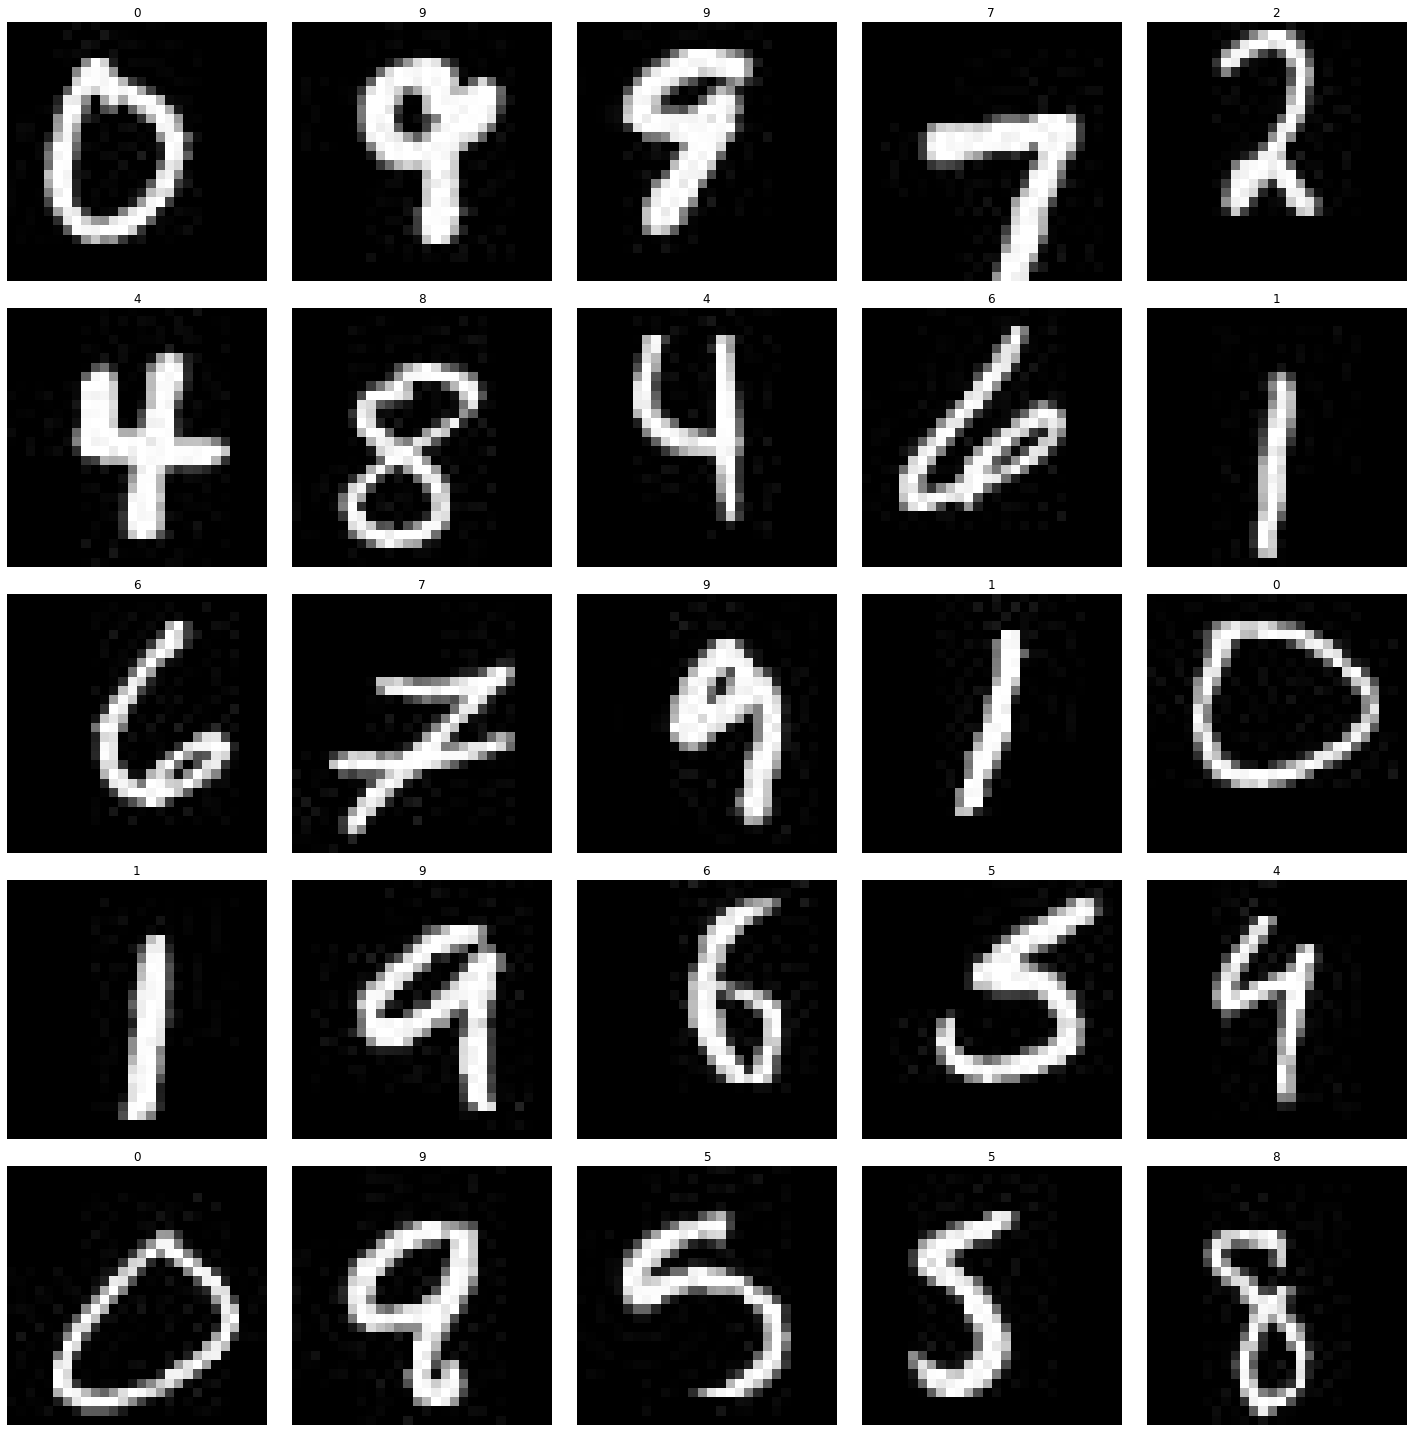

In [5]:
data.show_batch()

### Attempt 1

Just stick with resnet 18 and see how it goes.

In [6]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

In [7]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02
Min loss divided by 10: 2.09E-02


In [8]:
learn.fit_one_cycle(12, max_lr=0.05)

KeyboardInterrupt: 

In [9]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy, pretrained=False)

In [10]:
learn.unfreeze()

In [11]:
learn.fit_one_cycle(12, max_lr=0.05)

Traceback (most recent call last):
  File "/home/matthew/.pyenv/versions/3.7.3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/matthew/.pyenv/versions/3.7.3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/matthew/.pyenv/versions/3.7.3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/matthew/.pyenv/versions/3.7.3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/matthew/.pyenv/versions/3.7.3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/matthew/.pyenv/versions/3.7.3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])

KeyboardInterrupt: 

### Attempt 2

It's clear that the resnet 18 model has not done so well.
The lack of scaling may be the problem.

The fastai course at this point introduces a custom model which is shaped around the 28x28 original images.
It halves the size of them at each point (so 28->14->7->4->2->1) at which point it is the prediction for one of 10 classes.

The fastai course loads the images as monochrome, and I set up my images to be color.
For now lets make the input 3 channels.
I can change this to flatten the image afterwards.

In [14]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [15]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [19]:
model = nn.Sequential(
    conv_and_res(3, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [20]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [21]:
learn.fit_one_cycle(10, max_lr=0.1)

In [22]:
learn.save('04-custom-model-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


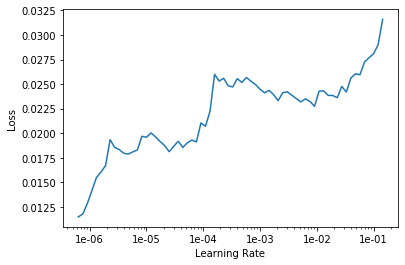

In [24]:
learn.lr_find()
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(10, max_lr=0.01)

In [29]:
learn.save('04-custom-model-2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


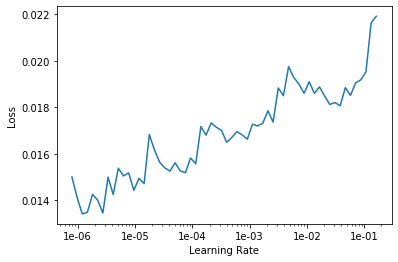

In [28]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(10, max_lr=0.001)

In [32]:
??learn.unfreeze

Signature: learn.unfreeze()
Source:   
    def unfreeze(self):
        "Unfreeze entire model."
        self.freeze_to(0)
File:      ~/.local/share/virtualenvs/digit-recognizer-1OQ1lSOx/lib/python3.7/site-packages/fastai/basic_train.py
Type:      method


In [43]:
[requires_grad(m) for m in learn.model]

[True, True, True, True, True, None]

In [44]:
learn.model[-1]

Flatten()

In [46]:
learn = learn.load('04-custom-model-2')

In [48]:
learn.fit_one_cycle(10, max_lr=0.1)

In [49]:
learn.save('04-custom-model-3')

In [50]:
learn.fit_one_cycle(10, max_lr=0.01)

### Submission

After repeated training this is clearly closer than the original model.
I can submit this and see how well I did.

In [51]:
def predict(model, path):
    image = open_image(path)
    prediction, _, _ = model.predict(image)
    return prediction

/home/matthew/Programming/Kaggle/digit-recognizer/data/processed/test/000000.jpg 2


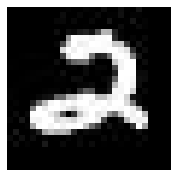

In [52]:
path = sorted(TEST_FOLDER.ls())[0]
image = open_image(path)
prediction, _, _ = learn.predict(image)
show_image(image)
print(path, prediction)

In [53]:
paths = sorted(TEST_FOLDER.ls())
ids = list(range(1, len(paths) + 1))
predictions = [
    predict(learn, path)
    for path in tqdm(paths)
]
len(ids)==len(predictions)

True

In [54]:
df = pd.DataFrame({'ImageId': ids, 'Label': predictions}).set_index('ImageId')

In [55]:
df.head()

Label
ImageId      
1           2
2           0
3           9
4           0
5           3

In [56]:
df.to_csv(SUBMISSION_CSV)

was: `1686 Matthew Franglen 0.98271`<br/>
now: `0731 Matthew Franglen 0.99428`